<a href="https://colab.research.google.com/github/saquibali7/EyeGazing/blob/main/EyeGazing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(-0.5, 224.5, 224.5, -0.5)

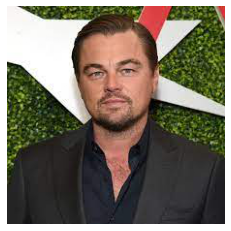

In [3]:
file = '/content/drive/MyDrive/EyeGazing/ldc.jpg'
orig_img = load_img(file)
orig_img = img_to_array(orig_img)
orig_img= orig_img/255.0
plt.imshow(orig_img)
plt.axis("off")


In [4]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import cv2


In [9]:
img = cv2.imread(file)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/EyeGazing/face.xml')
faces = face_cascade.detectMultiScale(gray_img)



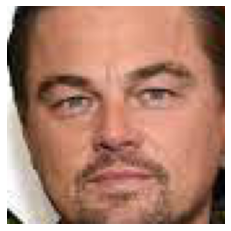

In [10]:
for i in range(len(faces)):
  x=faces[i][0]
  y=faces[i][1]
  w=faces[i][2]
  h=faces[i][3]
  plt.imshow(orig_img[y:y+h,x:x+w])
  plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 224.5, 224.5, -0.5)

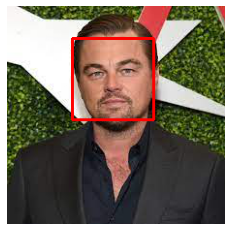

In [11]:
for i in range(len(faces)):
  x=faces[i][0]
  y=faces[i][1]
  w=faces[i][2]
  h=faces[i][3]
  cv2.rectangle(orig_img, (x,y), (x+w,y+h), (255,0,0),2)

plt.imshow(orig_img)
plt.axis("off")



In [12]:
eye_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/EyeGazing/eye.xml')
eyes = eye_cascade.detectMultiScale(gray_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 224.5, 224.5, -0.5)

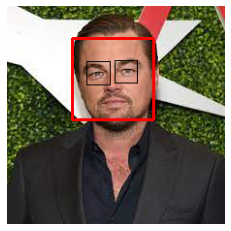

In [13]:


for i in range(len(eyes)):
  x=eyes[i][0]
  y=eyes[i][1]
  w=eyes[i][2]
  h=eyes[i][3]
  cv2.rectangle(orig_img, (x,y), (x+w,y+h), (0,0,0),1)

plt.imshow(orig_img)
plt.axis("off")

## Dataset visualisation and preprocessing

In [14]:
from numpy import load
from numpy.random import randint

In [15]:
dataset = load('/content/drive/MyDrive/EyeGazing/eye_tracker_train_and_val.npz')

In [16]:
dataset.files

['train_y',
 'train_eye_right',
 'train_face',
 'train_eye_left',
 'val_face',
 'val_eye_right',
 'train_face_mask',
 'val_y',
 'val_face_mask',
 'val_eye_left']

In [17]:
def normalize(data):
  shape = data.shape
  data = np.reshape(data, (shape[0], -1))
  data = data.astype('float32') / 255
  data = data - np.mean(data, axis=0)
  return np.reshape(data, shape)

In [18]:
train_face = normalize(dataset['train_face'][:15000])
train_left_eye = normalize(dataset['train_eye_left'][:15000])
train_right_eye= normalize(dataset['train_eye_right'][:15000])
train_face_mask = normalize(dataset['train_face_mask'][:15000])
train_y = dataset['train_y'][:15000].astype('float32')

In [19]:
train_y.shape

(15000, 2)

In [20]:
test_face = normalize(dataset['val_face'])
test_left_eye = normalize(dataset['val_eye_left'])
test_right_eye = normalize(dataset['val_eye_right'])
test_face_mask = normalize(dataset['val_face_mask'])
test_y = dataset['val_y'].astype('float32')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


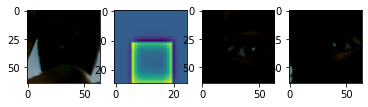

In [21]:
idx = randint(0,len(train_face))

plt.subplot(1,4,1)
plt.imshow(train_face[idx])
plt.subplot(1,4,2)
plt.imshow(train_face_mask[idx])
plt.subplot(1,4,3)
plt.imshow(train_left_eye[idx])
plt.subplot(1,4,4)
plt.imshow(train_right_eye[idx])

  


## Model Architecture and Training

In [22]:
from numpy.random import randint
from keras import initializers
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout, Flatten
from keras.layers import BatchNormalization, LayerNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.layers import Concatenate
from keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from numpy import reshape
from tensorflow.keras import regularizers
WEIGHT_DECAY = 0.001

In [23]:
def conv_layer(img):
  d = Conv2D(96, kernel_size=11, strides=4, padding='same',activation='relu',kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(img)     
  d = MaxPooling2D(pool_size=3, strides=2)(d)
  d = tf.nn.local_response_normalization(d, depth_radius=5, bias=1, alpha=0.0001, beta=0.75)
  d = Conv2D(256, kernel_size=5, strides=1, padding='same',groups=2,activation='relu',kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(d)                                
  d = MaxPooling2D(pool_size=3, strides=2)(d) 
  d = tf.nn.local_response_normalization(d, depth_radius=5, bias=1, alpha=0.0001, beta=0.75)                                            
  d = Conv2D(384, kernel_size=3, strides=1, padding='same', activation='relu',kernel_regularizer=regularizers.l2(WEIGHT_DECAY),)(d)                                                                                   
  d = Conv2D(64, kernel_size=1, strides=1, padding='same', activation='relu',kernel_regularizer=regularizers.l2(WEIGHT_DECAY),)(d)
  output = tf.reshape(d,[-1,576])                                                                    

  return output


In [24]:
def face_layer(img):
  inp = conv_layer(img)
  d = Dense(128, activation='relu',  kernel_initializer='random_normal')(inp)
  out = Dense(64, activation='relu', kernel_initializer='random_normal')(d)
  
  return out

In [25]:
def grid_layer(img):
  d = tf.reshape(img,[-1,625])
  d = Dense(256, activation='relu', kernel_initializer='random_normal')(d)                           
  out = Dense(128, activation='relu', kernel_initializer='random_normal')(d)

  return out


In [26]:

def ITrackerModel(faces_shape, eyesLeft_shape, eyesRight_shape, faceGrids_shape):
  faces = Input(faces_shape)
  eyesLeft = Input(eyesLeft_shape)
  eyesRight = Input(eyesRight_shape)
  face_grid = Input(faceGrids_shape)

  xEyeL = conv_layer(eyesLeft)
  xEyeR = conv_layer(eyesRight)

  xEyes = tf.concat([xEyeL, xEyeR], 1)
  eyesFC = Dense(128, activation='relu')(xEyes)

  faceFC = face_layer(faces)
  faceGridFC = grid_layer(face_grid)

  inpFC = tf.concat([eyesFC,faceFC,faceGridFC],1)
  d = Dense(128, activation='relu')(inpFC)
  output = Dense(2)(d)

  model = Model([faces,eyesLeft,eyesRight,face_grid], output)
  opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
  model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
  return model

### Only for training

In [ ]:
train_face.shape[1:],train_left_eye.shape[1:],train_right_eye.shape[1:],train_face_mask.shape[1:]

((64, 64, 3), (64, 64, 3), (64, 64, 3), (25, 25))

In [ ]:
model = ITrackerModel(train_face[1:],train_left_eye[1:],train_right_eye[1:],train_face_mask[1:])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit([train_face,train_left_eye,train_right_eye,train_face_mask],train_y, 
                    callbacks=[callback],validation_split = 0.1,
                    epochs=50, batch_size=32,verbose=0)

In [ ]:
model.save('/content/drive/MyDrive/model/EyeGazing20000.model')

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

### loading the trained model

In [27]:
model = tf.keras.models.load_model('/content/drive/MyDrive/EyeGazing/EyeGazing20000.model')

In [28]:
model.predict([train_face[10:11],train_left_eye[10:11],train_right_eye[10:11],train_face_mask[10:11]])

array([[-3.255964  ,  0.39386892]], dtype=float32)

In [29]:
train_y[10:11]

array([[-3.6430247,  0.969375 ]], dtype=float32)

## Gaze Prediction

In [30]:
def preprocess_image(img, shape):
  img = tf.image.resize(img,shape)
  img = normalize(img)
  img = tf.expand_dims(img, axis=0)

  return img

In [31]:
def preprocess_grid(grid):
  grid = tf.expand_dims(grid, axis=2)
  grid = tf.image.resize(grid,(25,25))
  img = tf.reshape(grid, (25,25))
  img = normalize(img)
  img = tf.expand_dims(img, axis=0)

  return img

In [32]:
def realTimeEyeGaze(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  face_grid = np.zeros((img.shape[0],img.shape[1]), dtype=int)
  face_axis = face_cascade.detectMultiScale(gray_img)
  eye_axis =  eye_cascade.detectMultiScale(gray_img)
  left_eye=[]
  right_eye=[]
  face_img=[]
   
  if(len(face_axis)==1 and len(eye_axis)==2):

    for(x, y, w, h) in face_axis:
      face_img = img[y:y+h,x:x+w]
      face_grid[y:y+h,x:x+w]=1

    for i in range(len(eye_axis)):
      x=eyes[i][0]
      y=eyes[i][1]
      w=eyes[i][2]
      h=eyes[i][3]
      if(i==1):
        left_eye = img[y:y+h,x:x+w]
      else:
        right_eye = img[y:y+h,x:x+w] 

    face_img = preprocess_image(face_img,(64,64))
    left_eye = preprocess_image(left_eye,(64,64))
    right_eye = preprocess_image(right_eye,(64,64))
    face_grid = preprocess_grid(face_grid)

    output = model.predict([face_img,left_eye,right_eye,face_grid])
    x = output[0][0]
    y = output[0][1]
    return x,y

  return False
  

In [160]:
screen_w = 5.58
screen_h = 5.45
screen_aspect = screen_w / screen_h
camera_l = 2.299
camera_t = 0.91
screen_t = 1.719
screen_l = 0.438
phone_w = 6.727
phone_h = 13.844
screen_from_camera = [screen_t - camera_t, screen_l - camera_l]

camera_coords_percentage = [camera_t / phone_h, camera_l / phone_w]

screenW = 375
screenH = 667

phone_w_to_screen = phone_w / screen_w
phone_h_to_screen = phone_h / screen_h



def makeCircle(img1, x, y):
  full_image = np.ones((round(img1.shape[0] * 2), round(img1.shape[1] * 2), 3), dtype=np.uint8)
  full_image_center = [round(full_image.shape[0] * 0.2), round(full_image.shape[1] *.5)]
  camera_center = full_image_center
  
  cm_to_px = img1.shape[0] * 1. / screen_h
  
  screen_from_camera_px = [round(screen_from_camera[0] * cm_to_px), round(screen_from_camera[1] * cm_to_px)]
  screen_start = [camera_center[0] + screen_from_camera_px[0], camera_center[1] + screen_from_camera_px[1]]
  full_image[screen_start[0]:screen_start[0] + img1.shape[0], screen_start[1]:screen_start[1] + img1.shape[1], :] = img1[:, :, :]

  pixelGaze = [round(camera_center[0] - y * cm_to_px), round(camera_center[1] + x * cm_to_px)]
  cv2.circle(full_image,(int(pixelGaze[1]), int(pixelGaze[0])), 2, (0, 0, 255), 2)
  
  return full_image,int(pixelGaze[1]), int(pixelGaze[0])

In [203]:
file = '/content/drive/MyDrive/EyeGazing/ldc.jpg'


In [216]:
img1 = cv2.imread(file)
if(realTimeEyeGaze(img1)):
  print(1)
  x, y= realTimeEyeGaze(img1)
  img1,x,y = makeCircle(img1,x,y)

  

1


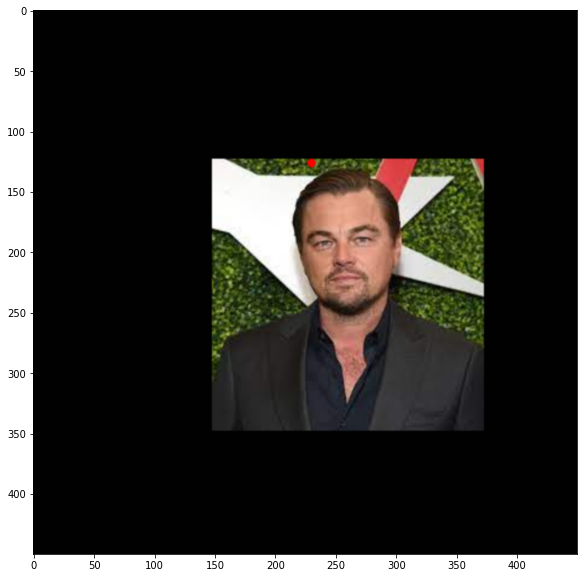

In [217]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), interpolation="bicubic")

## Template code for accessing real time camera in colab

In [67]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [68]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [70]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [71]:

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Real Time Colab Camera


In [210]:
video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    img = js_to_image(js_reply["img"])
    bbox_array = np.zeros([480,640,4], dtype=np.uint8) 

    if(realTimeEyeGaze(img)):
      x,y = realTimeEyeGaze(img)
      _,x,y = makeCircle(img,x,y)
      cv2.circle(bbox_array,(x,y), 2, (0, 0, 255), 2)
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

<IPython.core.display.Javascript object>